In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,f1_score, accuracy_score, recall_score,cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
import Kappas
from IPython.core.display import HTML
import pandas as pd
import os
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Palabras a ignorar (no incluir) en la trasformación de texto a vector de palabras
stopwords = ['@joebiden', '@americanair', '@jetblue','@hillaryclinton','@realdonaldtrump','rt','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

Dado el dataframe que contiene el conjunto de datos etiquetado (df), genera un dataframe (df_t)  con cada palabra encontrada en los textos (menos stopwords) como columnas, cada texto como fila y el número de apariciones de la palabra en el texto como valor.

In [2]:
def prepara_vector(df):
    y_real =  df['real'].tolist()
    palabras = set()
    textos = []
    raw_texto = df['texto'].tolist()
    y = []
    n_palabras = 0
    # Transforma los textos en vectores de palabras (textos) y genera el conjunto de palabras totales distintas entre todos los textos (palabras)
    for i in range(len(raw_texto)):
        t = raw_texto[i]
        label = y_real[i]
        texto = []
 
        # Separa el texto como vector de palabras (texto) y añade cada palabra al conjunto total de palabras (palabras)
        for s in t.split(' '): # s es una palabra
            if s not in stopwords:
                n_palabras += 1
                palabras.add(s)
                texto.append(s)

        # Añade a la lista de total de textos el texto como vector de palabras 
        if len(texto)>0:
            textos.append(texto)
            y.append(label)

    print(len(palabras), ' palabras en ', n_palabras,' palabras')

    # Genera los vectores de palabras (filas)
    n_palabras = len(palabras)
    palabras = list(palabras)
    vectores = []
    for texto in textos:        
        vector = [0]*n_palabras # Genera el vector relleno con ceros
        # Añade el número de apariciones de cada palabra del texto en el vector
        for palabra in texto:
            vector[palabras.index(palabra)]+=1
        
        vectores.append(vector)

    # Se genera el dataframe final con los vectores de apariciones como filas y las palabras como columnas
    df_t = pd.DataFrame(vectores,columns=palabras)

    return df_t, y

Dado el dataframe de vectores de palabras (df_t), el método, el número de intentos y el tamaño de entrenamiento

Realiza el entrenamiento, hace la predicción y calcula las métricas Kappa, Kappa con pesos cuadráticos y Kappa penalizada intentos número de veces

Devuelve el dataframe (df) con los valores de las métricas

In [35]:
# Método general.
# Se crea el modelo prediciendo el test y prediciendo el train.
# En ambos casos se obtienen las distintas métricas.
# Return: df con los resultados
def curva_aprendizaje(df_t, y, metodo, intentos, predecir_train=False):
    
    step = 0.05

    test_prop = 0.9

    resultados_train = []
    resultados_test = []
    while test_prop >= 0.2:
        step_mean_train = []
        step_mean_test = []
        resultado_step_train = []
        resultado_step_test = []

        for i in range(intentos):
            X_train, X_test, y_train, y_test = train_test_split(df_t, y, test_size=test_prop)
            rf  = metodo.fit(X_train, y_train)
            
            # Train            

            y_pred_train = rf.predict(X_train)
            res_train = Kappas.calcula_kappas(y_train, y_pred_train)

            # Test
            y_pred_test = rf.predict(X_test)
            res_test = Kappas.calcula_kappas(y_test, y_pred_test)
                            
            resultado_step_train.append(res_train)
            resultado_step_test.append(res_test)

        df_train = pd.DataFrame(resultado_step_train, columns =['kappa','qwkappa', 'pkappa'])
        df_test = pd.DataFrame(resultado_step_test, columns =['kappa','qwkappa', 'pkappa'])

        step_mean_train.append(1 - test_prop)
        step_mean_train.append(df_train["kappa"].mean())
        step_mean_train.append(df_train["qwkappa"].mean())
        step_mean_train.append(df_train["pkappa"].mean())
        
        resultados_train.append(step_mean_train)

        step_mean_test.append(1 - test_prop)
        step_mean_test.append(df_test["kappa"].mean())
        step_mean_test.append(df_test["qwkappa"].mean())
        step_mean_test.append(df_test["pkappa"].mean())
        
        resultados_train.append(step_mean_train)
        resultados_test.append(step_mean_test)
        
        test_prop = round(test_prop - step, 2)
    
    kappas_train = pd.DataFrame(resultados_train, columns =['tam. train', 'kappa','qwkappa','pkappa'])
    kappas_test = pd.DataFrame(resultados_test, columns =['tam. train', 'kappa','qwkappa','pkappa'])


    return df_metricas

7112  palabras en  19724  palabras


In [6]:
# Carga
path = "https://raw.githubusercontent.com/raqblanc/analsis-sentimiento-contexto-competitivo/main/data/trump-2020.csv"
df = pd.read_csv(path)
df_t, y = prepara_vector(df)

# Modelización y predicción
intentos = 1
arboles = 10
metodo = RandomForestClassifier(n_estimators = arboles)
curva_train, curva_test = curva_aprendizaje(df_t, y, metodo, intentos)

kappas_train, kappas_test

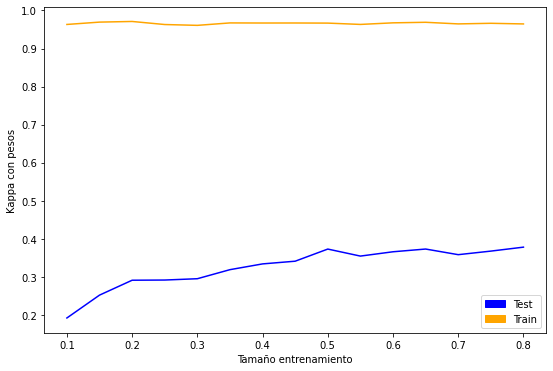

In [36]:
plt.figure(figsize=(9, 6))
plt.plot(curva_train['tam. train'], curva_train['pkappa'], color = 'orange')

train_patch = mpatches.Patch(color='orange', label='Train')
test_patch = mpatches.Patch(color='blue', label='Test')
plt.legend(handles=[test_patch, train_patch])

plt.ylabel('Kappa con pesos')
plt.xlabel('Tamaño entrenamiento')

plt.plot(curva_test['tam. train'], curva_test['pkappa'], color='blue')

plt.show()